In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import datetime
from shapely.geometry import Point
import geopandas as gpd
import imageio

sns.set()

DATA_DIR = Path('../data/')
pd.set_option('max_columns', 999)

# Loading data

In [2]:
# Extract list of dates, list of calendar filepaths, list of listing filepaths
dates = [re.findall(r'_20(\d{2})-(\d{2})-(\d{2}).*', cal_file.stem)[0] for cal_file in DATA_DIR.iterdir() if 'calendar' in cal_file.stem]
cal_files = [cal_file for cal_file in DATA_DIR.iterdir() if 'calendar' in cal_file.stem]
listing_files = [listing_file for listing_file in DATA_DIR.iterdir() if 'listing' in listing_file.stem]

In [3]:
list(enumerate(dates))

[(0, ('16', '04', '03')),
 (1, ('16', '05', '02')),
 (2, ('16', '06', '02')),
 (3, ('16', '07', '02')),
 (4, ('16', '08', '02')),
 (5, ('16', '09', '02')),
 (6, ('16', '10', '01')),
 (7, ('16', '11', '02')),
 (8, ('16', '12', '03')),
 (9, ('17', '01', '01')),
 (10, ('17', '02', '02')),
 (11, ('17', '03', '02')),
 (12, ('17', '04', '02')),
 (13, ('17', '05', '02')),
 (14, ('17', '06', '02')),
 (15, ('17', '07', '02')),
 (16, ('17', '08', '02')),
 (17, ('17', '09', '02')),
 (18, ('17', '10', '02')),
 (19, ('17', '11', '01')),
 (20, ('17', '12', '02')),
 (21, ('18', '01', '10')),
 (22, ('18', '02', '02')),
 (23, ('18', '03', '04')),
 (24, ('18', '04', '06')),
 (25, ('18', '05', '09'))]

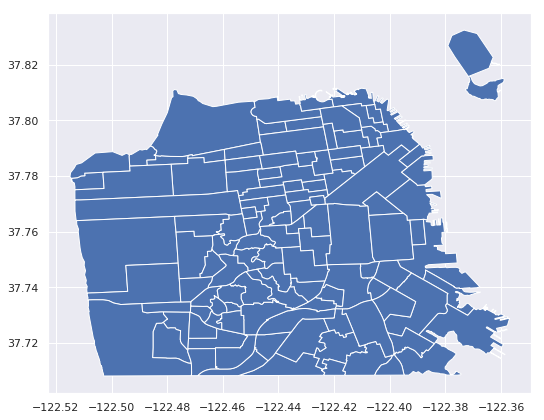

In [4]:
neighborhoods = gpd.read_file('../data/SF Find Neighborhoods.geojson')

fig, ax = plt.subplots(figsize=(10, 7))
neighborhoods.plot(ax=ax);

In [5]:
neighborhoods.head(10)

,link,name,geometry
0,"http://en.wikipedia.org/wiki/Sea_Cliff,_San_Fr...",Seacliff,(POLYGON ((-122.4934552679999 37.7835181710000...
1,None,Lake Street,(POLYGON ((-122.4871507149999 37.7837854270000...
2,http://www.nps.gov/prsf/index.htm,Presidio National Park,(POLYGON ((-122.4775801709999 37.8109931130000...
3,None,Presidio Terrace,(POLYGON ((-122.4724105299999 37.7873465390000...
4,http://www.sfgate.com/neighborhoods/sf/innerri...,Inner Richmond,(POLYGON ((-122.4726257899999 37.7863148060000...
5,None,Sutro Heights,(POLYGON ((-122.5031047159999 37.7812963820000...
6,None,Lincoln Park / Ft. Miley,(POLYGON ((-122.4933261399999 37.7817429920000...
7,http://www.sfgate.com/neighborhoods/sf/outerri...,Outer Richmond,(POLYGON ((-122.5131612759999 37.7750080590000...
8,http://www.sfgate.com/neighborhoods/sf/goldeng...,Golden Gate Park,(POLYGON ((-122.5131405409999 37.7713311150000...
9,http://en.wikipedia.org/wiki/Neighborhoods_in_...,Presidio Heights,(POLYGON ((-122.4594574409999 37.7894979240000...


# Pipeline for extracting data for events

In [6]:
def get_cal_data(event_start, event_end, dates, cal_files, listing_files):
    final_cal = None
    for date, cal, listing in zip(dates, cal_files, listing_files):
        data = pd.read_csv(cal, compression='gzip')
        listing_type = pd.read_csv(listing, compression='gzip')[['id', 'latitude', 'longitude', 'room_type']]
        
        data = pd.merge(data, listing_type, left_on='listing_id', right_on='id', how='left')
        data['date'] = pd.to_datetime(data['date'])
        data['price'] = (
            data
            .loc[:, 'price']
            .str.extract(r'\$(.*)', expand=False)
            .str.replace(r',', '')
            .astype(np.float_)
        )
        subset = data[(data['date'] >= event_start) & (data['date'] <= event_end)]
        subset['scraped'] = pd.Timestamp(2000 + int(date[0]), int(date[1]), int(date[2]))
        if final_cal is None:
            final_cal = subset
        else:
            final_cal = pd.concat([final_cal, subset])
    
    del data
    return final_cal

In [7]:
def geometrize(cal, neighborhoods):
    crs = {'init':'epsg:4326'}
    geometry = [Point(xy) for xy in zip(cal['longitude'], cal['latitude'])]
    cal = gpd.GeoDataFrame(cal, crs=crs, geometry=geometry)
    
    return gpd.sjoin(cal, neighborhoods, how='left', op='intersects')

In [8]:
def get_images(geo_df, neighborhoods, date_range, event_name):    
    for room_type in geo_df['room_type'].unique():
        max_price = geo_dreamforce[geo_dreamforce['room_type'] == room_type]['price'].quantile(.90)
        for date in date_range:
            output_df = (
                pd.merge(
                    geo_df[(geo_df['date'] == date) & (geo_df['room_type'] == room_type)].groupby('name').median()[['price']],
                    neighborhoods,
                    left_index=True, right_on='name',
                    how='outer'
                )
                .set_geometry('geometry')
            )

            fig, ax = plt.subplots(figsize=(10, 7))

            output_df[output_df.isnull().any(axis=1)].plot(ax=ax, color='grey')
            output_df.dropna().plot(ax=ax, column='price', cmap='OrRd', legend=True, vmin=0, vmax=max_price)

            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            fig.get_axes()[1].set_ylabel('Price ($)')
            plt.title(event_name.capitalize() + ' ' + room_type.lower() + ': ' + str(date.date()))

            filename = '../img/' + event_name + '/' + event_name + '_' + re.sub(r'/', '_', room_type) + \
                '_' + str(date.date()) + '.png'
            print('Saving', filename, '...')
            plt.savefig(filename)
            plt.close()

# Dreamforce

In [9]:
DREAMFORCE_START = pd.Timestamp(2017, 10, 31)
DREAMFORCE_END = pd.Timestamp(2017, 11, 15)
DREAMFORCE_RANGE = pd.date_range(start=DREAMFORCE_START, end=DREAMFORCE_END)

dreamforce_cal = get_cal_data(DREAMFORCE_START, DREAMFORCE_END, [dates[18]], [cal_files[18]], [listing_files[18]])

/mnt/c/Users/Junseo/Documents/data-science/.env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/mnt/c/Users/Junseo/Documents/data-science/.env/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
geo_dreamforce = geometrize(dreamforce_cal, neighborhoods)

In [11]:
get_images(geo_dreamforce, neighborhoods, DREAMFORCE_RANGE, 'dreamforce')

Saving ../img/dreamforce/dreamforce_Private room_2017-10-31.png ...
Saving ../img/dreamforce/dreamforce_Private room_2017-11-01.png ...
Saving ../img/dreamforce/dreamforce_Private room_2017-11-02.png ...
Saving ../img/dreamforce/dreamforce_Private room_2017-11-03.png ...
Saving ../img/dreamforce/dreamforce_Private room_2017-11-04.png ...
Saving ../img/dreamforce/dreamforce_Private room_2017-11-05.png ...
Saving ../img/dreamforce/dreamforce_Private room_2017-11-06.png ...
Saving ../img/dreamforce/dreamforce_Private room_2017-11-07.png ...
Saving ../img/dreamforce/dreamforce_Private room_2017-11-08.png ...
Saving ../img/dreamforce/dreamforce_Private room_2017-11-09.png ...
Saving ../img/dreamforce/dreamforce_Private room_2017-11-10.png ...
Saving ../img/dreamforce/dreamforce_Private room_2017-11-11.png ...
Saving ../img/dreamforce/dreamforce_Private room_2017-11-12.png ...
Saving ../img/dreamforce/dreamforce_Private room_2017-11-13.png ...
Saving ../img/dreamforce/dreamforce_Private room

# Christmas/New Years

In [12]:
CHRISTMAS_START = pd.Timestamp(2017, 12, 18)
CHRISTMAS_END = pd.Timestamp(2018, 1, 5)
CHRISTMAS_RANGE = pd.date_range(start=CHRISTMAS_START, end=CHRISTMAS_END)

christmas_cal = get_cal_data(CHRISTMAS_START, CHRISTMAS_END, [dates[20]], [cal_files[20]], [listing_files[20]])

/mnt/c/Users/Junseo/Documents/data-science/.env/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
geo_christmas = geometrize(christmas_cal, neighborhoods)

In [14]:
get_images(geo_christmas, neighborhoods, CHRISTMAS_RANGE, 'christmas')

Saving ../img/christmas/christmas_Entire home_apt_2017-12-18.png ...
Saving ../img/christmas/christmas_Entire home_apt_2017-12-19.png ...
Saving ../img/christmas/christmas_Entire home_apt_2017-12-20.png ...
Saving ../img/christmas/christmas_Entire home_apt_2017-12-21.png ...
Saving ../img/christmas/christmas_Entire home_apt_2017-12-22.png ...
Saving ../img/christmas/christmas_Entire home_apt_2017-12-23.png ...
Saving ../img/christmas/christmas_Entire home_apt_2017-12-24.png ...
Saving ../img/christmas/christmas_Entire home_apt_2017-12-25.png ...
Saving ../img/christmas/christmas_Entire home_apt_2017-12-26.png ...
Saving ../img/christmas/christmas_Entire home_apt_2017-12-27.png ...
Saving ../img/christmas/christmas_Entire home_apt_2017-12-28.png ...
Saving ../img/christmas/christmas_Entire home_apt_2017-12-29.png ...
Saving ../img/christmas/christmas_Entire home_apt_2017-12-30.png ...
Saving ../img/christmas/christmas_Entire home_apt_2017-12-31.png ...
Saving ../img/christmas/christmas_

# SF Pride

In [15]:
PRIDE_START = pd.Timestamp(2017, 6, 18)
PRIDE_END = pd.Timestamp(2017, 6, 30)
PRIDE_RANGE = pd.date_range(PRIDE_START, PRIDE_END)

pride_cal = get_cal_data(PRIDE_START, PRIDE_END, [dates[14]], [cal_files[14]], [listing_files[14]])

/mnt/c/Users/Junseo/Documents/data-science/.env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/mnt/c/Users/Junseo/Documents/data-science/.env/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
geo_pride = geometrize(pride_cal, neighborhoods)

In [17]:
get_images(geo_pride, neighborhoods, PRIDE_RANGE, 'pride')

Saving ../img/pride/pride_Private room_2017-06-18.png ...
Saving ../img/pride/pride_Private room_2017-06-19.png ...
Saving ../img/pride/pride_Private room_2017-06-20.png ...
Saving ../img/pride/pride_Private room_2017-06-21.png ...
Saving ../img/pride/pride_Private room_2017-06-22.png ...
Saving ../img/pride/pride_Private room_2017-06-23.png ...
Saving ../img/pride/pride_Private room_2017-06-24.png ...
Saving ../img/pride/pride_Private room_2017-06-25.png ...
Saving ../img/pride/pride_Private room_2017-06-26.png ...
Saving ../img/pride/pride_Private room_2017-06-27.png ...
Saving ../img/pride/pride_Private room_2017-06-28.png ...
Saving ../img/pride/pride_Private room_2017-06-29.png ...
Saving ../img/pride/pride_Private room_2017-06-30.png ...
Saving ../img/pride/pride_Entire home_apt_2017-06-18.png ...
Saving ../img/pride/pride_Entire home_apt_2017-06-19.png ...
Saving ../img/pride/pride_Entire home_apt_2017-06-20.png ...
Saving ../img/pride/pride_Entire home_apt_2017-06-21.png ...
Sa

# Outside Lands

In [18]:
OSL_START = pd.Timestamp(2017, 8, 7)
OSL_END = pd.Timestamp(2017, 8, 18)
OSL_RANGE = pd.date_range(OSL_START, OSL_END)

osl_cal = get_cal_data(OSL_START, OSL_END, [dates[15]], [cal_files[15]], [listing_files[15]])

/mnt/c/Users/Junseo/Documents/data-science/.env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/mnt/c/Users/Junseo/Documents/data-science/.env/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [19]:
geo_osl = geometrize(osl_cal, neighborhoods)

In [20]:
get_images(geo_osl, neighborhoods, OSL_RANGE, 'osl')

Saving ../img/osl/osl_Entire home_apt_2017-08-07.png ...
Saving ../img/osl/osl_Entire home_apt_2017-08-08.png ...
Saving ../img/osl/osl_Entire home_apt_2017-08-09.png ...
Saving ../img/osl/osl_Entire home_apt_2017-08-10.png ...
Saving ../img/osl/osl_Entire home_apt_2017-08-11.png ...
Saving ../img/osl/osl_Entire home_apt_2017-08-12.png ...
Saving ../img/osl/osl_Entire home_apt_2017-08-13.png ...
Saving ../img/osl/osl_Entire home_apt_2017-08-14.png ...
Saving ../img/osl/osl_Entire home_apt_2017-08-15.png ...
Saving ../img/osl/osl_Entire home_apt_2017-08-16.png ...
Saving ../img/osl/osl_Entire home_apt_2017-08-17.png ...
Saving ../img/osl/osl_Entire home_apt_2017-08-18.png ...
Saving ../img/osl/osl_Private room_2017-08-07.png ...
Saving ../img/osl/osl_Private room_2017-08-08.png ...
Saving ../img/osl/osl_Private room_2017-08-09.png ...
Saving ../img/osl/osl_Private room_2017-08-10.png ...
Saving ../img/osl/osl_Private room_2017-08-11.png ...
Saving ../img/osl/osl_Private room_2017-08-12.

# July 4th

In [21]:
JULY4_START = pd.Timestamp(2017, 6, 26)
JULY4_END = pd.Timestamp(2017, 7, 7)
JULY4_RANGE = pd.date_range(JULY4_START, JULY4_END)

july4_cal = get_cal_data(JULY4_START, JULY4_END, [dates[14]], [cal_files[14]], [listing_files[14]])

/mnt/c/Users/Junseo/Documents/data-science/.env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/mnt/c/Users/Junseo/Documents/data-science/.env/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [22]:
geo_july4 = geometrize(july4_cal, neighborhoods)

In [23]:
get_images(geo_july4, neighborhoods, JULY4_RANGE, 'july4')

Saving ../img/july4/july4_Private room_2017-06-26.png ...
Saving ../img/july4/july4_Private room_2017-06-27.png ...
Saving ../img/july4/july4_Private room_2017-06-28.png ...
Saving ../img/july4/july4_Private room_2017-06-29.png ...
Saving ../img/july4/july4_Private room_2017-06-30.png ...
Saving ../img/july4/july4_Private room_2017-07-01.png ...
Saving ../img/july4/july4_Private room_2017-07-02.png ...
Saving ../img/july4/july4_Private room_2017-07-03.png ...
Saving ../img/july4/july4_Private room_2017-07-04.png ...
Saving ../img/july4/july4_Private room_2017-07-05.png ...
Saving ../img/july4/july4_Private room_2017-07-06.png ...
Saving ../img/july4/july4_Private room_2017-07-07.png ...
Saving ../img/july4/july4_Entire home_apt_2017-06-26.png ...
Saving ../img/july4/july4_Entire home_apt_2017-06-27.png ...
Saving ../img/july4/july4_Entire home_apt_2017-06-28.png ...
Saving ../img/july4/july4_Entire home_apt_2017-06-29.png ...
Saving ../img/july4/july4_Entire home_apt_2017-06-30.png ...

# Animation

In [24]:
for dir_ in Path('../img').iterdir():
    event_name = dir_.stem
    (dir_/'mvimg').mkdir(exist_ok=True)
    for room_type in ['Entire home_apt', 'Private room', 'Shared room']:
        images = []
        
        for filename in dir_.glob('*' + room_type + '*'):
            images.append(imageio.imread(filename))
        imageio.mimsave(dir_/'mvimg'/(event_name + '_' + room_type + '.gif'), images, duration=0.75)